In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra

target(x::Float64) = (x^3-15*x^2+7*x+1)/10
target_ravine(p) = sum(p .* p)
target_ravine_2(p) = p[1]^2 + 100*p[2]^2
simplex_test_func(x) = 3*(x[1]-5)^2 + 7*(x[2]-10)^2
fly_func(x) = (x[1]-2*x[2])^2 + (x[2]-9)^2
function target_rastrygin(p)
    A = 10
    result = A*length(p)
    for idx in 1:length(p)
        result += p[idx]^2 - A*cos(2*pi*p[idx])
    end
    return result
end
function target_schefill(p)
    A = 418.9829
    result = A*length(p)
    for idx in 1:length(p)
        result -= p[idx]*sin(sqrt(abs(p[idx])))
    end
    return result
end
target_rosenbrock(p) = (1 - p[1])^2 + 100*(p[2] - p[1]^2)^2

global Lf_max=0
function df(f, points)
    result = []
    for idx in 2:length(points)-1
        push!(result, (f(points[idx+1]) - f(points[idx-1]))/(points[idx+1]-points[idx-1]))
        global Lf_max = max(Lf_max, max(abs(result[end])))
    end
    return result
end

function grad(f, x, eps=1e-6)
    result = zeros(length(x))
    for i in 1:length(x)
        next_x = copy(x)
        next_x[i] += eps
        result[i] = (f(next_x) - f(x)) / eps
    end
    return result
end

function hess(func, x, eps=1.e-6)
    __sz = length(x)
    result = zeros(__sz, __sz)
    for i in 1:__sz
        for j in 1:__sz
            next_x_i = copy(x)
            next_x_i[i] += eps
            next_x_j = copy(x)
            next_x_j[j] += eps
            next_x_ij = copy(x)
            next_x_ij[i] += eps
            next_x_ij[j] += eps
            result[i,j] = (func(next_x_ij) - func(next_x_j) - func(next_x_j) + func(x))/eps^2 
        end
    end
    return result
end

function ddf(f, points)
    result = []
    for idx in 2:length(points)-1
        push!(result, (f(points[idx+1]) - 2 * f(points[idx]) + f(points[idx-1]))/(points[idx+1]-points[idx])^2)
    end
    return result
end

function ddf_with_points(f, points)
    result = []
    for idx in 2:length(points)-1
        push!(result, (f(points[idx+1]) - 2 * f(points[idx]) + f(points[idx-1]))/(points[idx+1]-points[idx])^2)
    end
    return result, points[2:length(points)-1]
end

function get_fib(n)
    sqrt5 = sqrt(5)
    trunc(Int, (1 / sqrt5) * (((1 + sqrt5) / 2)^n - ((1  - sqrt5) / 2)^n))
end

function is_unimodal_df(f, a, b, N=1000)
    deriv = df(f, range(a, b, N))
    last_deriv = deriv[1]
    for current_deriv in deriv[2:length(deriv)-1]
        if current_deriv <= last_deriv
            return false
        end
    end
    return true
end

function is_unimodal_ddf(f, a, b, N=1000)
    for current_deriv in ddf(f, range(a, b, N))
        if current_deriv < 0
            return false
        end
    end
    return true
end

function search_unimodal_segment(f, a, b, N=1000)
    deriv, points = ddf_with_points(f, range(a, b, N))
    interval_start, interval_end = nothing, nothing
    result_start, result_end = nothing, nothing
    for (second_deriv, point) in zip(deriv, points)
        if second_deriv < 0
            if interval_start != nothing
                if (interval_end - interval_start) > (result_end - result_start)
                    result_start, result_end = interval_start, interval_end
                end
                interval_start = nothing
                interval_end = nothing
            end
        elseif second_deriv > 0
            if interval_start == nothing
                interval_start = point
            end
            interval_end = point
        end
    end
    if result_end == nothing || result_start == nothing
        return interval_start, interval_end    
    end
    if (interval_end - interval_start) > (result_end - result_start)
        result_start, result_end = interval_start, interval_end
    end
    return result_start, result_end
end

function nnorm(p)
    return sqrt(sum(p .* p))
end

minimumby(f, iter) = reduce(iter) do x, y
    f(x) < f(y) ? x : y
end
minimum_idx_by(f, iter) = reduce(1:length(iter)) do x, y
    f(iter[x]) < f(iter[y]) ? x : y
end

minimum_idx_by (generic function with 1 method)

In [3]:
function __bsr_intrin(value)
    result = 0
    while (1 << result) < value
        result += 1
    end
    return result
end

function mutate(population, bit_length; mut_prob=0.3, DIMS=2)
    Threads.@threads for i in 1:length(population)
        for j in 1:DIMS
            if rand() < mut_prob
                population[i][j] = xor(population[i][j], 1 << rand(0:bit_length))
            end
        end
    end
end

function genetics_min(func, bounds; population_size=10, max_iter=1000, mut_prob=0.3, DIMS = 2, stop=false, eps=1e-3, values_type=UInt, log_every=1, verbose_every=0, slow_mutation_every=300)
    population = [[values_type(rand(bounds[1]:bounds[2])) for j in 1:DIMS] for i in 1:population_size]
    max_shift_idx = Base.top_set_bit(max(bounds...)) - 1
    iterations = 0
    history = [population[1]]
    global_min = zeros(DIMS)
    global_min_val = Inf
    children = [values_type.(zeros(DIMS)) for i in 1:population_size]
    generation = [population..., children...]
    for idx in 1:max_iter
        iterations += 1
        Threads.@threads for pop_idx in 1:2:population_size
            pair_idx = -1
            while pair_idx == -1 || pair_idx == pop_idx
                pair_idx = rand(1:population_size)
            end
            for j in 1:DIMS
                mask_right = (1 << rand(1:max_shift_idx)) - 1
                mask_left = ~mask_right
                children[pop_idx][j] = clamp((population[pop_idx][j] & mask_right) | (population[pair_idx][j] & mask_left), bounds...)
                children[pop_idx+1][j] = clamp((population[pop_idx][j] & mask_left) | (population[pair_idx][j] & mask_right), bounds...)
            end
        end
        mutate(children, max_shift_idx, mut_prob=mut_prob, DIMS=DIMS)
        generation[1:population_size] = population
        generation[population_size+1:end] = children
        sort!(generation, by=func)
        population = generation[1:population_size]
        for idx in 1:length(population)
            if global_min_val > func(population[idx])
                global_min_val = func(population[idx])
                global_min = population[idx]
            end
        end
        if slow_mutation_every > 0 && iterations % slow_mutation_every == 0
            mut_prob /= 2
        end
        if log_every > 0 && iterations % log_every == 0
            push!(history, copy(global_min))
        end
        if verbose_every > 0 && iterations % verbose_every == 0
            println("iteration: $(iterations), best_score: $(global_min_val)")
            flush(stdout)
        end
        if stop && abs(global_min_val) < eps
            break
        end
    end
    return global_min, iterations, history
end

@enum LossFunctionType EuclidNorm BooleanNorm

function generate_target_function(target, type = EuclidNorm)
    __target = Float32.(target)
    function euclid_loss_function(x)
        v = (__target - Float32.(x))
        return sqrt(dot(v,v))
    end
    function boolean_loss_function(x)
        return sum(target .!= x)
    end
    if type == EuclidNorm
        return euclid_loss_function
    else
        return boolean_loss_function
    end        
end

function generate_target_img(size=3)
    result = zeros(UInt8, size^2) .+ 0x6
    for idx in 1:size
        result[trunc(UInt8, size/2)+1 + (idx-1)*size] = 3
        result[(trunc(UInt8, size/2))*size + idx] = 3
        result[(idx-1)*size+idx] = 0
        result[size-idx+1 + (idx-1)*size] = 0
    end
    return result
end

function generate_colored_img(size=3)
    result = zeros(UInt8, (size^2,3)) .+ 0x7
    for idx in 1:size
        result[trunc(UInt8, size/2)+1 + (idx-1)*size,:] = UInt8.(rand(0:7, 3))
        result[(trunc(UInt8, size/2))*size + idx,:] = UInt8.(rand(0:7, 3))
        result[(idx-1)*size+idx,:] = [0x0, 0x0, 0x0]
        result[size-idx+1 + (idx-1)*size,:] = [0x0, 0x0, 0x0]
    end
    return reshape(result, 3*size^2)
end

generate_colored_img (generic function with 2 methods)

In [5]:
sizes = [3, 5, 9, 21]
imgs = []
tf = []
for size in sizes
    im = generate_target_img(size)
    push!(imgs, im)
    push!(tf, generate_target_function(im))
end
results = []
for idx in 1:length(tf)
    @time result, iterations, history = genetics_min(tf[idx], [0, 6], population_size=1000, max_iter=500, stop=true, DIMS=sizes[idx]^2, mut_prob=0.01, values_type=UInt8)
    push!(results, [result, iterations, history])
    println("size: $(sizes[idx]), iterations: $(iterations), score: $(tf[idx](result))")
    flush(stdout)
end

  0.052910 seconds (3.94 M allocations: 171.961 MiB, 15.88% gc time)
size: 3, iterations: 13, score: 0.0
  2.427073 seconds (159.50 M allocations: 10.287 GiB, 11.23% gc time)
size: 5, iterations: 500, score: 1.0
  4.419854 seconds (217.94 M allocations: 26.459 GiB, 13.08% gc time)
size: 9, iterations: 500, score: 3.0
 18.264747 seconds (585.99 M allocations: 133.112 GiB, 13.57% gc time)
size: 21, iterations: 500, score: 10.770329


In [7]:
b_tf = []
for im in imgs
    push!(b_tf, generate_target_function(im, BooleanNorm))
end
b_results = []
for idx in 1:length(tf)
    result, iterations, history = genetics_min(b_tf[idx], [0, 6], population_size=1000, max_iter=500, stop=true, DIMS=sizes[idx]^2, mut_prob=0.01)
    push!(b_results, [result, iterations, history])
    println("size: $(sizes[idx]), result: $(result), iterations: $(iterations), score: $(b_tf[idx](result))")
end

size: 3, result: UInt64[0x0000000000000000, 0x0000000000000003, 0x0000000000000000, 0x0000000000000003, 0x0000000000000000, 0x0000000000000003, 0x0000000000000000, 0x0000000000000003, 0x0000000000000000], iterations: 13, score: 0
size: 5, result: UInt64[0x0000000000000000, 0x0000000000000006, 0x0000000000000003, 0x0000000000000006, 0x0000000000000000, 0x0000000000000006, 0x0000000000000000, 0x0000000000000003, 0x0000000000000000, 0x0000000000000006, 0x0000000000000003, 0x0000000000000003, 0x0000000000000000, 0x0000000000000003, 0x0000000000000003, 0x0000000000000006, 0x0000000000000000, 0x0000000000000003, 0x0000000000000000, 0x0000000000000006, 0x0000000000000000, 0x0000000000000006, 0x0000000000000003, 0x0000000000000006, 0x0000000000000000], iterations: 183, score: 0
size: 9, result: UInt64[0x0000000000000000, 0x0000000000000006, 0x0000000000000006, 0x0000000000000006, 0x0000000000000003, 0x0000000000000006, 0x0000000000000006, 0x0000000000000006, 0x0000000000000000, 0x0000000000000

In [9]:
sizes = [3, 5, 9, 21]
colored_imgs = []
colored_tf = []
for size in sizes
    im = generate_colored_img(size)
    push!(colored_imgs, im)
    push!(colored_tf, generate_target_function(im))
end
c_results = []
for idx in 1:length(colored_tf)
    @time result, iterations, history = genetics_min(colored_tf[idx], [0, 7], population_size=1000, max_iter=500, stop=true, DIMS=3*sizes[idx]^2, mut_prob=0.01, values_type=UInt8)
    push!(c_results, [result, iterations, history])
    println("size: $(sizes[idx]), result: $(result), iterations: $(iterations), score: $(colored_tf[idx](result))")
    flush(stdout)
end

  2.676116 seconds (162.05 M allocations: 11.349 GiB, 13.52% gc time)
size: 3, result: UInt8[0x00, 0x05, 0x00, 0x03, 0x00, 0x02, 0x00, 0x00, 0x00, 0x00, 0x06, 0x00, 0x05, 0x00, 0x04, 0x00, 0x01, 0x00, 0x00, 0x07, 0x00, 0x04, 0x00, 0x06, 0x00, 0x06, 0x00], iterations: 500, score: 1.0
  4.463872 seconds (212.19 M allocations: 24.389 GiB, 14.98% gc time)
size: 5, result: UInt8[0x00, 0x05, 0x01, 0x07, 0x00, 0x07, 0x00, 0x01, 0x00, 0x07, 0x07, 0x01, 0x00, 0x07, 0x07, 0x07, 0x00, 0x06, 0x00, 0x07, 0x00, 0x07, 0x04, 0x07, 0x00, 0x00, 0x07, 0x03, 0x07, 0x00, 0x07, 0x00, 0x04, 0x00, 0x07, 0x00, 0x01, 0x00, 0x02, 0x05, 0x07, 0x00, 0x07, 0x00, 0x07, 0x00, 0x07, 0x07, 0x07, 0x00, 0x00, 0x07, 0x02, 0x07, 0x00, 0x07, 0x00, 0x01, 0x00, 0x07, 0x05, 0x05, 0x00, 0x04, 0x00, 0x07, 0x00, 0x05, 0x00, 0x07, 0x00, 0x07, 0x02, 0x07, 0x00], iterations: 500, score: 3.1622777
 11.395691 seconds (386.84 M allocations: 73.447 GiB, 14.35% gc time)
size: 9, result: UInt8[0x00, 0x07, 0x07, 0x07, 0x03, 0x07, 0x07, 0x0

In [15]:
for sz_idx in 1:length(sizes)
    initial_matrix = reshape(imgs[sz_idx], (sizes[sz_idx], sizes[sz_idx]))
    anim = @animate for idx in 1:length(results[sz_idx][3])
        current_matrix = reshape(results[sz_idx][3][idx], (sizes[sz_idx], sizes[sz_idx]))
        p1 = Plots.heatmap(initial_matrix, c=:grays, title="Начальное изображение", clims=(0,7), colorbar=false)
        p2 = Plots.heatmap(current_matrix, c=:grays, title="$(idx)/$(length(results[sz_idx][3]))\nDist: $(tf[sz_idx](results[sz_idx][3][idx]))", clims=(0,7), colorbar=false)
        Plots.plot(p1, p2)
    end
    gif(anim, "lab-img-gen-$(sizes[sz_idx])-ec.gif", fps=10)
end

[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-3-ec.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-5-ec.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-9-ec.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-21-ec.gif


In [16]:
for sz_idx in 1:length(sizes)
    anim = @animate for idx in 1:length(b_results[sz_idx][3])
        current_matrix = reshape(b_results[sz_idx][3][idx], (sizes[sz_idx], sizes[sz_idx]))
        initial_matrix = reshape(imgs[sz_idx], (sizes[sz_idx], sizes[sz_idx]))
        p1 = Plots.heatmap(initial_matrix, c=:grays, title="Начальное изображение", clims=(0,7), colorbar=false)
        p2 = Plots.heatmap(current_matrix, c=:grays, title="$(idx)/$(length(b_results[sz_idx][3]))\nBoolDist: $(b_tf[sz_idx](results[sz_idx][3][idx]))", clims=(0,7), colorbar=false)
        Plots.plot(p1, p2)
    end
    gif(anim, "lab-img-gen-$(sizes[sz_idx])-bc.gif", fps=10)
end

[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-3-bc.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-5-bc.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-9-bc.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-img-gen-21-bc.gif


In [17]:
for sz_idx in 1:length(sizes)
    initial_matrix = reshape(colored_imgs[sz_idx], (sizes[sz_idx], sizes[sz_idx], 3))
    initial_colors = [[RGB((initial_matrix[i,j,:]/0x7...)) for i in 1:sizes[sz_idx]] for j in 1:sizes[sz_idx]]
    initial_img = hcat(initial_colors...)
    anim = @animate for idx in 1:length(c_results[sz_idx][3])
        current_matrix =  reshape(c_results[sz_idx][3][idx], (sizes[sz_idx], sizes[sz_idx], 3))
        current_colors = [[RGB((current_matrix[i,j,:]/0x7...)) for i in 1:sizes[sz_idx]] for j in 1:sizes[sz_idx]]
        current_img = hcat(current_colors...)
        p1 = Plots.plot(initial_img, title="Начальное изображение")
        p2 = Plots.plot(current_img, title="$(idx)/$(length(c_results[sz_idx][3]))\nDist: $(colored_tf[sz_idx](c_results[sz_idx][3][idx]))")
        Plots.plot(p1, p2)
    end
    gif(anim, "lab-colimg-gen-$(sizes[sz_idx])-ec.gif", fps=10)
end

[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-colimg-gen-3-ec.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-colimg-gen-5-ec.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-colimg-gen-9-ec.gif
[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-colimg-gen-21-ec.gif


In [4]:
#import Pkg; Pkg.add("ImageMagick")
using ImageMagick
unpack_val(x) = [x.r.i, x.g.i, x.b.i]

target_img = open("target_image_l.png") do io
    ImageMagick.load(io)
end
image_vector = reduce(vcat, reshape(unpack_val.(target_img), prod(size(target_img))))

7500-element Vector{UInt8}:
 0xa3
 0x28
 0x69
 0xbf
 0x29
 0x80
 0xc3
 0x2f
 0x84
 0xc1
 0x2b
 0x81
 0xc1
    ⋮
 0xf1
 0xa1
 0xc4
 0xf1
 0xa1
 0xc4
 0xf1
 0xa1
 0xc4
 0xf2
 0xa2
 0xc5

In [7]:
image_tf = generate_target_function(image_vector)
result, iterations, history = genetics_min(image_tf, [0, 255], population_size=250, max_iter=2000, stop=true, DIMS=length(image_vector), mut_prob=0.01, values_type=UInt8, verbose_every=5, log_every=50)

iteration: 5, best_score: 8303.325
iteration: 10, best_score: 8202.035
iteration: 15, best_score: 8091.892
iteration: 20, best_score: 8035.096
iteration: 25, best_score: 7984.4893
iteration: 30, best_score: 7926.9097
iteration: 35, best_score: 7882.3276
iteration: 40, best_score: 7832.293
iteration: 45, best_score: 7795.811
iteration: 50, best_score: 7748.6978
iteration: 55, best_score: 7716.5303
iteration: 60, best_score: 7688.4673
iteration: 65, best_score: 7651.1167
iteration: 70, best_score: 7618.271
iteration: 75, best_score: 7585.141
iteration: 80, best_score: 7552.304
iteration: 85, best_score: 7521.662
iteration: 90, best_score: 7494.271
iteration: 95, best_score: 7453.9985
iteration: 100, best_score: 7424.9473
iteration: 105, best_score: 7400.131
iteration: 110, best_score: 7375.878
iteration: 115, best_score: 7342.6655
iteration: 120, best_score: 7307.8774
iteration: 125, best_score: 7278.4565
iteration: 130, best_score: 7254.5537
iteration: 135, best_score: 7226.483
iteratio

(UInt8[0xd1, 0x46, 0x3d, 0xd5, 0x45, 0x76, 0x93, 0x6d, 0x85, 0x69  …  0x9b, 0xdc, 0xb5, 0x68, 0xe7, 0xcf, 0xf2, 0xe2, 0x5a, 0xd1], 2000, Vector{UInt8}[[0xbf, 0x37, 0x19, 0x19, 0x7f, 0x4a, 0x71, 0x67, 0x8e, 0x90  …  0x0c, 0x62, 0x4e, 0xbe, 0x3b, 0x6a, 0xa7, 0x3c, 0xc6, 0xa2], [0x9a, 0x0a, 0x1f, 0x5a, 0xd9, 0xef, 0x2a, 0x5d, 0xb1, 0x5a  …  0xd9, 0x78, 0xb9, 0xc0, 0x60, 0x49, 0xb0, 0x1c, 0x7a, 0xed], [0x9a, 0x4a, 0x1f, 0x5a, 0xdb, 0xef, 0x2a, 0x55, 0xb1, 0x18  …  0x9b, 0x78, 0xb9, 0xc0, 0x62, 0x49, 0xf0, 0x1c, 0x7a, 0xed], [0x9a, 0x4a, 0x1f, 0x1c, 0xd3, 0xef, 0xaa, 0x55, 0x91, 0x90  …  0x9b, 0x78, 0x9b, 0xc0, 0x66, 0x4d, 0xf0, 0x18, 0x7a, 0xed], [0x1a, 0x4a, 0x1f, 0x5c, 0xd3, 0xeb, 0xba, 0x45, 0xf3, 0x98  …  0x9b, 0x78, 0x99, 0x48, 0x66, 0x49, 0xf1, 0x18, 0x7a, 0xad], [0x98, 0x4a, 0x9f, 0xde, 0x93, 0xea, 0xba, 0x55, 0xf1, 0xbc  …  0x9b, 0x78, 0x99, 0x68, 0xe7, 0x49, 0xf1, 0x59, 0x7a, 0xad], [0xd8, 0x4a, 0x9f, 0xdf, 0x97, 0x6a, 0xba, 0xd5, 0xd1, 0xb8  …  0x9b, 0x7c, 0x99, 0x6a, 0xe7, 0x49,

[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab9/lab-huge_img-gen-lera-50.gif


Plots.AnimatedGif("/home/user/code/BMSTU/Optimizers/lab9/lab-huge_img-gen-lera-50.gif")
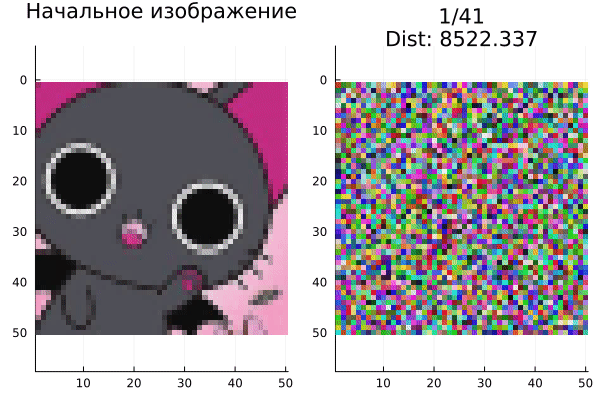

In [8]:
initial_matrix = reshape(image_vector, (3, size(target_img)...))
initial_colors = [[RGB((initial_matrix[:,i,j]/0xff...)) for i in 1:size(target_img)[1]] for j in 1:size(target_img)[2]]
initial_img = hcat(initial_colors...)
anim = @animate for idx in 1:length(history)
    current_matrix =  reshape(history[idx], (3, size(target_img)...))
    current_colors = [[RGB((current_matrix[:,i,j]/0xff...)) for i in 1:size(target_img)[1]] for j in 1:size(target_img)[2]]
    current_img = hcat(current_colors...)
    p1 = Plots.plot(initial_img, title="Начальное изображение")
    p2 = Plots.plot(current_img, title="$(idx)/$(length(history))\nDist: $(image_tf(history[idx]))")
    Plots.plot(p1, p2)
end
gif(anim, "lab-huge_img-gen-lera-$(size(target_img)[1]).gif", fps=2)

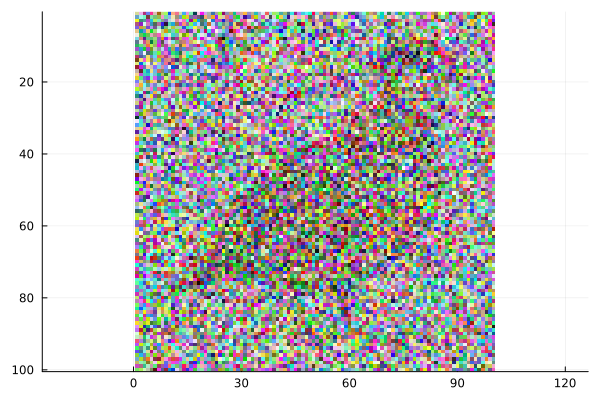

In [60]:
test = reshape(result, (3,size(target_img)...))
test1 = [[RGB((test[:,i,j]/0xff...)) for i in 1:size(target_img)[1]] for j in 1:size(target_img)[2]]
test2 = hcat(test1...)
Plots.plot(test2)